## Book Sales - EDA & Transformation

วิเคราะห์ข้อมูลยอดขายหนังสือจากไฟล์ CSV ด้วย PySpark เพื่อเตรียมข้อมูลสำหรับนำไปใช้ในขั้นตอนถัดไปของ data pipeline เช่น การโหลดลง data warehouse หรือการทำ dashboard

In [6]:
import os
os.environ["JAVA_HOME"] = "C:/Java/jdk-11.0.28.6-hotspot"
os.environ["SPARK_HOME"] = "C:/Spark/spark-3.4.4-bin-hadoop3"

import findspark
findspark.init()

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName("test") \
  .getOrCreate()

### 1. Initialize Spark Session

- สร้าง SparkSession เพื่อใช้ประมวลผลข้อมูลด้วย PySpark

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Book Sales - EDA & Transform") \
    .master("local[*]") \
    .getOrCreate()


### 2. Load Raw Data

- โหลดข้อมูลจากไฟล์ CSV ที่เก็บข้อมูลยอดขายหนังสือแบบ mock

In [9]:
df = spark.read.csv("../data/raw/book_sales_mock_data.csv", header=True, inferSchema=True)

### 3. Initial Data Exploration and Exploratory Data Analysis (EDA)

  ##### 3.1 Schema and Sample

- ดู schema และตัวอย่างข้อมูลเพื่อตรวจสอบว่า column มีชนิดข้อมูลถูกต้องหรือไม่

In [10]:
df.printSchema() # แสดงรายละเอียด Schema
df.show(5) # แสดงตาราง

root
 |-- order_id: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- category: string (nullable = true)
 |-- store_location: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price_per_unit: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- total_price: double (nullable = true)

+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|   book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|    1001|The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash| 24/5/2024|    1105.95|
|    1002|Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|  9/6/2024|    1507.85|
|    1003|     Becoming|  History|       Bangko

##### 3.2 Missing Values

- ตรวจสอบว่าคอลัมน์ใดมี missing/null values ที่อาจต้องจัดการ

- `null` — คือค่าที่ “ไม่มีข้อมูล” หรือ “ว่าง” ใช้ได้กับทุกชนิดข้อมูล (string, number, date, ฯลฯ)

- `NaN` — เป็นค่าพิเศษที่เกิดกับข้อมูลตัวเลข (float, double) แสดงว่า “ค่าไม่ใช่ตัวเลข” ค่าที่ข้อมูลเสียหาย

1.กรณีที่มี data type เป็น string ทั้งหมดหาแค่ค่า `null` ให้ใช้แบบนี้

In [11]:
from pyspark.sql.functions import col, when, count

# นับจำนวนหาค่า null
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|       0|         0|       0|             0|       1|             0|             0|         0|          1|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+



2.กรณีที่มี data type มี float, double อยู่ด้วยต้องหา `null` และ `NaN` ให้ใช้แบบนี้ 

In [12]:
from pyspark.sql.functions import col, isnan, count, when
from pyspark.sql.types import FloatType, DoubleType, NumericType

# นับจำนวนหาค่า null และ NaN
def count_missing(df):
    exprs = []
    for c, dtype in df.dtypes:
        if dtype in ('float', 'double'):
            expr = count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
        else:
            expr = count(when(col(c).isNull(), c)).alias(c)
        exprs.append(expr)
    return df.select(exprs)

count_missing(df).show()


+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|       0|         0|       0|             0|       1|             0|             0|         0|          1|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+



##### ❌กรณีที่เจอค่า null

##### ✅ เช็กแถวที่มี null

In [13]:
# เลือกแถวที่ column 'total_price' เป็น null
df.filter(col("total_price").isNull()).show()

+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|          book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|    1014|The Midnight Library| Fiction|    Chiang Mai|       1|        236.77|   Credit Card| 30/1/2024|       null|
+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------+



##### ✅ เช็กทุกแถวที่มี null

In [14]:
from functools import reduce
from pyspark.sql.functions import col

# สร้าง filter สำหรับทุก column
null_filter = [col(c).isNull() for c in df.columns]
df.filter(reduce(lambda a, b: a | b, null_filter)).show()

+--------+--------------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|          book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+--------------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|    1014|The Midnight Library|  Fiction|    Chiang Mai|       1|        236.77|   Credit Card| 30/1/2024|       null|
|    1042|            Educated|Biography|       Bangkok|    null|        153.64|          Cash|  3/1/2024|     614.56|
+--------+--------------------+---------+--------------+--------+--------------+--------------+----------+-----------+



##### ดังนั้นเวลาตรวจสอบข้อมูล

- เราเช็คชนิดข้อมูล (dtype) ของแต่ละคอลัมน์

- สำหรับ string หรือชนิดอื่น ๆ ที่ไม่ใช่ตัวเลข → เช็คแค่ `null` ก็พอ

- สำหรับ ตัวเลข (float, double) → ควรเช็คทั้ง `null` และ `NaN` เพื่อครอบคลุมทุกกรณี


การจัดการกับ missing value

- `fillna` และ `dropna` คือ 2 วิธีหลักในการจัดการ Missing Values (NaN)

In [80]:
df_cleaned = df.fillna(0)
# → เติม 0 แทนค่า missing

หรือ

In [16]:
from pyspark.sql import functions as F

# 1. คำนวณค่าเฉลี่ยของ total_price
mean_value = df.select(F.mean("total_price")).collect()[0][0]

# 2. ใช้ fillna เพื่อเติมช่องว่างด้วยค่า mean
df_cleaned = df.fillna({"total_price": mean_value})

df_cleaned.show()

+--------+--------------------+---------+--------------+--------+--------------+--------------+----------+-----------------+
|order_id|          book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|      total_price|
+--------+--------------------+---------+--------------+--------+--------------+--------------+----------+-----------------+
|    1001|       The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash| 24/5/2024|          1105.95|
|    1002|       Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|  9/6/2024|          1507.85|
|    1003|            Becoming|  History|       Bangkok|       1|        152.88|   Credit Card|  5/6/2024|           152.88|
|    1004|       Atomic Habits|Self-Help|       Bangkok|       5|        173.21|          Cash| 20/5/2024|           866.05|
|    1005|       Atomic Habits|  Finance|     Khon Kaen|       3|         159.2|          Cash| 15/2/2024|            477.6|


In [19]:
df_cleaned.filter(df_cleaned.order_id == 1014).show()

+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------------+
|order_id|          book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|      total_price|
+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------------+
|    1014|The Midnight Library| Fiction|    Chiang Mai|       1|        236.77|   Credit Card| 30/1/2024|848.7104040404043|
+--------+--------------------+--------+--------------+--------+--------------+--------------+----------+-----------------+



👉 ลบแถวที่มี null:

In [11]:
df_cleaned =  df.dropna(subset=["total_price","quantity"])

In [67]:
# ลองตรวจสอบว่าลบค่า null แล้วไหม
df_cleaned.filter(reduce(lambda a, b: a | b, null_filter)).show()

+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+



##### 3.3 Summary Stats (เฉพาะ numeric column)

- ดูสถิติเบื้องต้น เช่น ค่ามากสุด น้อยสุด ค่าเฉลี่ย ของยอดขายและจำนวน

✅ 1. ดูค่าคร่าว ๆ ด้วย describe()

- ดู max ว่ามีค่าโดดสูงกว่าค่าอื่นหรือเปล่า

- ดู stddev ว่าเยอะจนบ่งบอกว่าข้อมูลกระจายมากเกินไปหรือไม่

In [13]:
df_cleaned.describe(["quantity", "price_per_unit" ,"total_price"]).show()

+-------+------------------+------------------+------------------+
|summary|          quantity|    price_per_unit|       total_price|
+-------+------------------+------------------+------------------+
|  count|                98|                98|                98|
|   mean| 2.989795918367347|249.95724489795904| 851.0996938775513|
| stddev|1.4537182894693896| 60.13809986371167|1021.7233795244754|
|    min|                 1|            152.17|            152.88|
|    max|                 5|             348.1|            9999.0|
+-------+------------------+------------------+------------------+



✅การวิเคราะห์:

- count = quantity และ total_price 99 ทั้งสอง → มี missing value

- mean ของ quantity = 2.9, 248.8, 749.8

- stddev ของ total_price ผิดปกติ

- max ของ total_price = 9999 → อาจมีการป้อนข้อมูลผิด

- ตรวจต่อว่า outlier หรือไม่ โดยใช้ IQR :

In [14]:
from pyspark.sql import functions as F

# df คือ PySpark DataFrame
quantiles = df.approxQuantile("total_price", [0.25, 0.75], 0.01) # มีพารามิเตอร์ที่ 3 คือ relativeError → ยิ่งเล็กยิ่งแม่น (แต่อาจช้าลง)
Q1, Q3 = quantiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower: {lower_bound}, Upper: {upper_bound}")

Lower: -624.5749999999999, Upper: 2025.705


- ค่าที่มีมากกว่า 2025.705 มีค่าผิดปกติเป็น outlier

หาค่าทั้งหมดที่เป็น outlier :

In [15]:
df.filter((col("total_price") < lower_bound) | (col("total_price") > upper_bound)).show()

+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|   book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|    1075|Atomic Habits| History|        Phuket|       1|        214.01|          Cash| 21/4/2024|     9999.0|
+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+



✅ 2. ต่อด้วย Boxplot หรือ Histogram (เมื่อเจอ outlier)

- เพื่อดูว่า outlier มีแค่ 1-2 ตัว หรือหลายตัวกระจุกอยู่แปลก ๆ

In [16]:
%pip install seaborn

You should consider upgrading via the 'c:\Users\Admin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


##### 📊 plot boxplot หลังทำ IQR

🎯 เป้าหมายของการ Plot:

- ✅ ดูการกระจายตัวของข้อมูล (Distribution)

- ✅ ดูว่ามี outlier จริงไหม และอยู่ห่างจากกลุ่มหลักแค่ไหน

- ✅ ดูว่า IQR ที่คุณใช้ detect มันเหมาะสมไหม

- ✅ ใช้ตรวจสอบ bias ในข้อมูล (เช่น skew ไปทางซ้าย/ขวา)

##### ⚠️ สิ่งที่ต้องระวัง

- อย่าสุ่มแบบไม่ fix `seed` เพราะอาจเจอหรือไม่เจอ outlier → ค่ากระจายอาจต่าง

- อย่าใช้ `.toPandas()` บน DataFrame ใหญ่ → ใช้ `.sample()` + `.collect()` แทน

- ถ้าไม่เห็น outlier บน boxplot = คุณอาจต้องเพิ่มจำนวน sample หรือรวม outlier เข้ามาให้ครบ

- คือถ้าใช้ sample มันจะสุ่มค่าบางส่วนนำไปแสดงแต่ถ้าใช้ toPandas มันจะแปลงค่าทั้งหมดมา **ห้าม** ใช้กับข้อมูลที่ Big Data

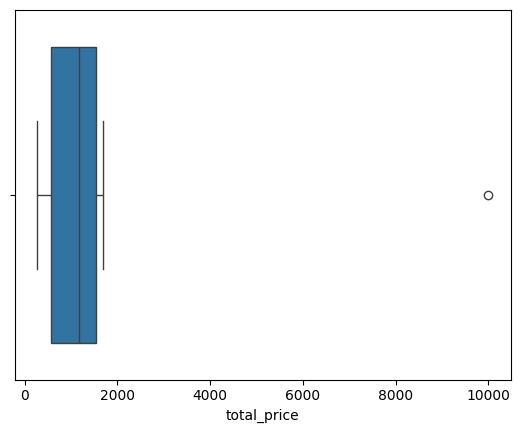

In [17]:
# Sample ข้อมูล แล้ว collect มาก่อน แทน toPandas() ตรง ๆ
sample_data = df_cleaned.select("total_price").sample(fraction=0.1, seed=42).limit(1000).collect()

# แปลงเป็น Pandas DataFrame ด้วยมือ
import pandas as pd

sample_df = pd.DataFrame(sample_data, columns=["total_price"]) # แปลงเป็น pandas

# Plot ด้วย seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=sample_df, x="total_price")
plt.show()


✅ สิ่งที่เห็นในกราฟ:

- เจอ outlier ด้านขวาสุดมีค่าประมาณ 10000

In [18]:
df_cleaned.filter((col("total_price") < lower_bound) | (col("total_price") > upper_bound)).show()

+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|   book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+
|    1075|Atomic Habits| History|        Phuket|       1|        214.01|          Cash| 21/4/2024|     9999.0|
+--------+-------------+--------+--------------+--------+--------------+--------------+----------+-----------+



 ##### เลือกว่าจะจัดการ outlier อย่างไร

- ❌ ตัดทิ้งเลย: ถ้ารู้ว่าเป็น noise หรือ error

- 🔄 แทนที่ด้วย median/mean: ถ้าไม่อยากให้เสีย record ไป

- ✅ เก็บไว้แยกวิเคราะห์ต่างหาก: ถ้าอยากศึกษาเฉพาะกลุ่มราคาสูง/ต่ำผิดปกติ

Filter แยกข้อมูลที่เป็น outlier และไม่เป็นออกจากกัน

- อาจดูหรือวิเคราะห์เฉพาะ outlier ถ้าต้องการ เช่น เอา outlier ไปดูว่าร้านไหนขายแพงผิดปกติ หรือมี error data

In [19]:
# ข้อมูลที่ไม่ใช่ outlier
df_no_outlier = df_cleaned.filter((col("total_price") >= lower_bound) & (col("total_price") <= upper_bound))

# ข้อมูลที่เป็น outlier
df_outlier = df_cleaned.filter((col("total_price") < lower_bound) | (col("total_price") > upper_bound))

ลองหาค่าที่เป็น outlier ใหม่ดู

In [20]:
df_no_outlier.filter((col("total_price") < lower_bound) | (col("total_price") > upper_bound)).show()

+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|book_title|category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+
+--------+----------+--------+--------------+--------+--------------+--------------+----------+-----------+



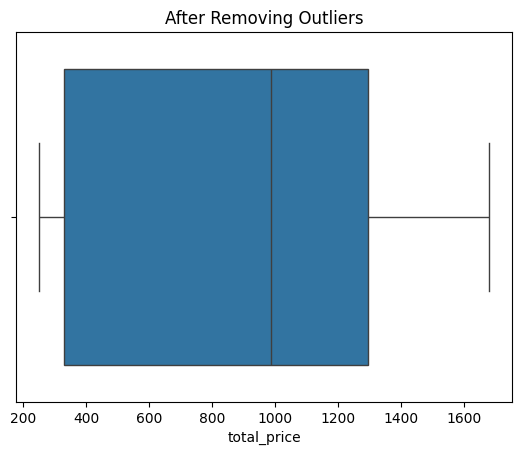

In [21]:
# Sample ใหม่จาก df_no_outlier
sample_no_outlier = df_no_outlier.select("total_price").sample(fraction=0.1, seed=42).limit(1000).collect()
sample_no_outlier_df = pd.DataFrame(sample_no_outlier, columns=["total_price"])

sns.boxplot(data=sample_no_outlier_df, x="total_price")
plt.title("After Removing Outliers")
plt.show()

✅ สิ่งที่เห็นในกราฟ:



- Median (Q2): เส้นกลางกล่อง อยู่ที่ประมาณ 1000 → เป็นค่ากลางของ total_price

- Q1 (25%): ขอบล่างของกล่องอยู่ที่ประมาณ 350

- Q3 (75%): ขอบบนของกล่องอยู่ที่ประมาณ 1300

- ไม่มีจุด outlier: ไม่มีจุด ● ที่อยู่นอก whiskers

  Whiskers:
  - ด้านซ้ายสิ้นสุดประมาณ 350
  
  - ด้านขวาสิ้นสุดประมาณ 1300

In [22]:
df_no_outlier.describe(["total_price"]).show()

+-------+------------------+
|summary|       total_price|
+-------+------------------+
|  count|                97|
|   mean| 756.7914432989693|
| stddev|417.24927537382064|
|    min|            152.88|
|    max|           1700.05|
+-------+------------------+



ลองนับจำนวน count ที่ได้จากการ clean ทั้งหมดดู

In [23]:
from pyspark.sql import functions as F

df_no_outlier.select([F.count(c).alias(f"{c}_count") for c in df_no_outlier.columns]).show()


+--------------+----------------+--------------+--------------------+--------------+--------------------+--------------------+----------------+-----------------+
|order_id_count|book_title_count|category_count|store_location_count|quantity_count|price_per_unit_count|payment_method_count|order_date_count|total_price_count|
+--------------+----------------+--------------+--------------------+--------------+--------------------+--------------------+----------------+-----------------+
|            97|              97|            97|                  97|            97|                  97|                  97|              97|               97|
+--------------+----------------+--------------+--------------------+--------------+--------------------+--------------------+----------------+-----------------+



### 4. Data Cleaning

#### ตัวอย่างการทำความสะอาดข้อมูล

##### 4.1 Convert Data Types

- แปลง column ประเภท string เช่น date เป็นแบบ date type ที่เหมาะสม

In [26]:
df_no_outlier.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- category: string (nullable = true)
 |-- store_location: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price_per_unit: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- total_price: double (nullable = true)



- แปลง `order_date` เป็น type date และจัด formate

In [41]:
from pyspark.sql.functions import to_date

# แปลง string to DateType ด้วย to_date
df_transformed = df_no_outlier.withColumn("order_date", to_date("order_date", "d/M/yyyy"))

df_transformed.show(5)

+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|order_id|   book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+
|    1001|The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash|2024-05-24|    1105.95|
|    1002|Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|2024-06-09|    1507.85|
|    1003|     Becoming|  History|       Bangkok|       1|        152.88|   Credit Card|2024-06-05|     152.88|
|    1004|Atomic Habits|Self-Help|       Bangkok|       5|        173.21|          Cash|2024-05-20|     866.05|
|    1005|Atomic Habits|  Finance|     Khon Kaen|       3|         159.2|          Cash|2024-02-15|      477.6|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----

✅ คำอธิบาย:

- `"order_date"`: คือชื่อ column เดิมที่เป็น string

- `"d/M/yyyy"`: รูปแบบของวันที่ที่คุณมีอยู่ — วันที่ไม่ต้องมี leading zero เช่น 21/4/2024

- `to_date(...)`: แปลง string เป็นชนิด `DateType`

In [42]:
df_transformed.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- category: string (nullable = true)
 |-- store_location: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price_per_unit: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- order_date: date (nullable = true)
 |-- total_price: double (nullable = true)



- แปลง `order_date` จาก Type String เป็น Date Type แล้ว

##### 4.2 Handle Missing or Incorrect Data

- ฉันทำไปแล้วในข้อที่ 3 จัดการข้อมูลที่เป็น missing และ outlier

### 5. Feature Engineering / Transfoemation

ขั้นตอนนี้มีเป้าหมายเพื่อ ปรับปรุงคุณภาพของข้อมูล ให้เหมาะกับการวิเคราะห์หรือส่งต่อไปยังขั้นตอน downstream (เช่น ML หรือ Dashboard)

##### 5.1 สร้าง revenue_per_item (ราคาขายต่อชิ้นจริง)

- ถ้าสนใจว่าราคาจริงๆ ที่ขายได้เฉลี่ยต่อชิ้นเท่าไร:

In [43]:
from pyspark.sql.functions import round

df_transformed = df_transformed.withColumn("revenue_per_unit", round(df_transformed.total_price / df_transformed.quantity, 2))

df_transformed.show(5)

+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+
|order_id|   book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|revenue_per_unit|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+
|    1001|The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash|2024-05-24|    1105.95|          221.19|
|    1002|Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|2024-06-09|    1507.85|          301.57|
|    1003|     Becoming|  History|       Bangkok|       1|        152.88|   Credit Card|2024-06-05|     152.88|          152.88|
|    1004|Atomic Habits|Self-Help|       Bangkok|       5|        173.21|          Cash|2024-05-20|     866.05|          173.21|
|    1005|Atomic Habits|  Finance|     Khon Kaen|       3|         159.2|          Cash|2024-02-1

##### 5.2 Extract Year and Month

- ดึง year, month ออกจากวันที่เพื่อใช้ในการสรุปยอดขายรายเดือน

In [44]:
from pyspark.sql.functions import month, year

df_transformed = df_transformed.withColumn("month", month("order_date")) \
                               .withColumn("year", year("order_date"))

df_transformed.show(5)

+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+-----+----+
|order_id|   book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|revenue_per_unit|month|year|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+-----+----+
|    1001|The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash|2024-05-24|    1105.95|          221.19|    5|2024|
|    1002|Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|2024-06-09|    1507.85|          301.57|    6|2024|
|    1003|     Becoming|  History|       Bangkok|       1|        152.88|   Credit Card|2024-06-05|     152.88|          152.88|    6|2024|
|    1004|Atomic Habits|Self-Help|       Bangkok|       5|        173.21|          Cash|2024-05-20|     866.05|          173.21|    5|2024|
|    1005|Atomic Hab

##### 5.3 Season (ฤดู) จากเดือน:

- เพิ่มคอลัมน์ระบุฤดูของไทย:

In [45]:
from pyspark.sql.functions import when

df_transformed = df_transformed.withColumn("season", 
    when(df_transformed.month.isin(11, 12, 1), "Cool")
    .when(df_transformed.month.isin(2, 3, 4), "Hot")
    .when(df_transformed.month.isin(5, 6, 7, 8, 9, 10), "Rainy")
)

df_transformed.show(5)

+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+-----+----+------+
|order_id|   book_title| category|store_location|quantity|price_per_unit|payment_method|order_date|total_price|revenue_per_unit|month|year|season|
+--------+-------------+---------+--------------+--------+--------------+--------------+----------+-----------+----------------+-----+----+------+
|    1001|The Alchemist|  History|    Chiang Mai|       5|        221.19|          Cash|2024-05-24|    1105.95|          221.19|    5|2024| Rainy|
|    1002|Atomic Habits|  Finance|        Phuket|       5|        301.57|   Credit Card|2024-06-09|    1507.85|          301.57|    6|2024| Rainy|
|    1003|     Becoming|  History|       Bangkok|       1|        152.88|   Credit Card|2024-06-05|     152.88|          152.88|    6|2024| Rainy|
|    1004|Atomic Habits|Self-Help|       Bangkok|       5|        173.21|          Cash|2024-05-20|     866.05|       

### 6. Aggregation and Summary

##### 6.1 Monthly Sales

- รวมยอดขายตามเดือนเพื่อดู performance รายเดือน

In [53]:
from pyspark.sql.functions import sum, round

monthly_sales = (
    df_transformed
    .groupBy("year", "month") # group by คือเอาแค่ที่ซ้ำ
    .agg(round(sum("total_price"), 2).alias("monthly_total")) # sum คือรวม round ใช้เพื่อแสดงทศนิยมแค่ 2 ตำแหน่ง / alias ตั้งชื่อ col ใหม่
    .orderBy("year", "month") # order คือเรียงลำดับ
)

monthly_sales.show()

+----+-----+-------------+
|year|month|monthly_total|
+----+-----+-------------+
|2024|    1|     10702.82|
|2024|    2|     14087.61|
|2024|    3|     11524.72|
|2024|    4|     12941.01|
|2024|    5|     10307.73|
|2024|    6|     13844.88|
+----+-----+-------------+



##### 6.2 Top Selling Books

- หาหนังสือขายดีอันดับต้นๆ จากยอดขายรวม

In [54]:
from pyspark.sql.functions import sum, round

top_books = (
    df_transformed
    .groupBy("book_title")
    .agg(round(sum("total_price"), 2).alias("total_revenue"))
    .orderBy("book_title")
)

top_books.show()


+--------------------+-------------+
|          book_title|total_revenue|
+--------------------+-------------+
|       Atomic Habits|     14004.57|
|            Becoming|     10610.69|
|            Educated|     12514.54|
|       The Alchemist|     17483.52|
|The Midnight Library|     18795.45|
+--------------------+-------------+



##### สรุปข้อมูลที่ได้

- ข้อมูลที่ได้จากการ tranformation

  - df_transformed : ข้อมูลทั้งหมด

  - monthly_sales : ข้อมูลแสดงยอดขายรายเดือน

  - top_books : ข้อมูลแสดงยอดขายทั้งหมดของหนังสือแต่ละเล่ม

### 7. Save Transformed Data

- บันทึกข้อมูลหลังจาก transform แล้วเป็นไฟล์ CSV สำหรับนำไปใช้ในขั้นตอนถัดไป เช่น Load เข้า Data Warehouse

✅ Tips

- ใช้ lowercase + underscore ในชื่อไฟล์ (ไม่เว้นวรรค)

- อย่าลืม .csv และใส่ header=True

- ถ้าอยาก versioning ก็เพิ่มวันที่ เช่น _v1, _20240731

In [56]:
df_cleaned.write.mode("overwrite").option("header", True).csv("../data/processed/book_sales_cleaned.csv")

monthly_sales.write.mode("overwrite").option("header", True).csv("../data/output/monthly_sales_summary.csv")

top_books.write.mode("overwrite").option("header", True).csv("../data/output/top_books_summary.csv")

- ถ้าเป็น Spark บันทึก `.csv` จะถูกเขียนเป็นโฟลเดอร์พร้อมไฟล์หลายพาร์ท (`part-0000...csv`)

- ถ้าอยากรวมเป็นไฟล์เดียวไว้ใช้ภายหลังได้ด้วย Pandas หลังจาก `.toPandas()` แล้ว `.to_csv()` อีกครั้ง